# Text classification with Transformer

---



**Author:** [Apoorv Nandan](https://twitter.com/NandanApoorv)<br>
**Date created:** 2020/05/10<br>
**Last modified:** 2020/05/10<br>
**Description:** Implement a Transformer block as a Keras layer and use it for text classification.

## Setup


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np


## Implement multi head self attention as a Keras layer


In [ ]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        """Reshape x to the shape (batch_size, -1, num_heads, embedding dimension.
        Used to obtain the separate attention heads in each for each batch."""
        # -1 to ensure the dimension of the reshaped tensor is compatible with
        # the original x
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        # ensure the transposed tensor dimensions are 0, 2, 1, 3
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        # Recombine the heads
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output



## Implement a Transformer block as a layer


In [ ]:
from keras.layers import LeakyReLU

def gelu(x):
    """Gaussian Error Linear Unit.
    This is a smoother version of the RELU.
    Original paper: https://arxiv.org/abs/1606.08415
    refer : https://github.com/google-research/bert/blob/bee6030e31e42a9394ac567da170a89a98d2062f/modeling.py#L264
    Args:
        x: float Tensor to perform activation.
    Returns:
        `x` with the GELU activation applied.
    """
    cdf = 0.5 * (1.0 + tf.tanh(
        (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

In [ ]:

class TransformerBlockWithLeakyRelu(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlockWithLeakyRelu, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            # note: we use GELU here to match out text
            # This is an addition to the existing code tutorial
            [layers.Dense(ff_dim, activation=gelu), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        # Multi-head attention
        attn_output = self.att(inputs)
        # Apply dropout
        attn_output = self.dropout1(attn_output, training=training)
        # Apply leakyrelu after each sublayer
        ## Added this to the existing code
        attn_output = LeakyReLU(alpha=0.01)(attn_output)
        # Add and norm
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        # Pass through FFNN, dropout again
        ffn_output = self.dropout2(ffn_output, training=training)
        # Apply leakyrelu after each sublayer
        ## Aded this to the existing code
        ffn_output = LeakyReLU(alpha=0.01)(ffn_output)
        # Final add and norm
        return self.layernorm2(out1 + ffn_output)



## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).


In [ ]:

class TokenAndPositionEmbedding(layers.Layer):
    """Add positional embedding"""
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions





# Load datasets: one dataset for each binary classification problem.


In [ ]:
vocab_size = 283 # includes special tokens
maxlen = 100 


In [ ]:
def split_and_convert(row):

  return [int(x) for x in row.split(" ")]


def load_data(class_label):

  train = pd.read_csv(f"/content/drive/My Drive/Research/CyberBERT/data/train_over_{class_label}.csv")
  valid = pd.read_csv(f"/content/drive/My Drive/Research/CyberBERT/data/valid_over_{class_label}.csv")
  test = pd.read_csv(f"/content/drive/My Drive/Research/CyberBERT/data/test_{class_label}.csv")

  return train, valid, test

def process_data(train, valid, test):

  train["calls"] = train["calls"].apply(lambda x: split_and_convert(x))
  valid["calls"] = valid["calls"].apply(lambda x: split_and_convert(x))
  test["calls"] = test["calls"].apply(lambda x: split_and_convert(x))

  y_train = np.asarray(train["label"])
  x_train = np.stack(np.asarray(train["calls"]),axis=0)

  y_val = np.asarray(valid["label"])
  x_val = np.stack(np.asarray(valid["calls"]),axis=0)

  y_test = np.asarray(test["label"])
  x_test = np.stack(np.asarray(test["calls"]),axis=0)

  return y_train, x_train, y_val, x_val, y_test, x_test

def load_and_process_data(class_label):

  train, valid, test = load_data(class_label)

  y_train, x_train, y_val, x_val, y_test, x_test = process_data(train, valid, test)

  return y_train, x_train, y_val, x_val, y_test, x_test

In [ ]:
# train = pd.read_csv("/content/drive/My Drive/Research/CyberBERT/data/train_over.csv")
# valid = pd.read_csv("/content/drive/My Drive/Research/CyberBERT/data/valid_over.csv")
# test = pd.read_csv("/content/drive/My Drive/Research/CyberBERT/data/test.csv")

## Create classifier model using transformer layer

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.


In [ ]:
def initialize_transformer():

  # Use leaky relu
  embed_dim = 32  # Embedding size for each token
  num_heads = 2  # Number of attention heads
  ff_dim = 32  # Hidden layer size in feed forward network inside transformer

  inputs = layers.Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerBlockWithLeakyRelu(embed_dim, num_heads, ff_dim)
  # TO DO: update this part of the model
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(32, activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(2, activation="softmax")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model



## Train and Evaluate


In [ ]:
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import SpatialDropout1D
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt 

In [ ]:
CLASSES = ["Adware", "Backdoor", "Downloader", "Dropper","Spyware", "Trojan", "Virus", "Worms"]

In [ ]:
def get_prediction_accuracy(y_test, x_test, model, class_label, history):
  y_test_pred = transformer.predict(x_test)
  y_classes = y_test_pred.argmax(axis=-1)
  cm = confusion_matrix(y_test, y_classes)

  cm = plot_confusion_matrix(conf_mat=cm,
                        show_absolute=True,
                        show_normed=True,
                        colorbar=True)
  plt.show()
  plt.savefig(f"confusion_matrix_{class_label}.png")

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.grid()
  plt.savefig(f"accuracy_{class_label}.png")
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.grid()
  plt.savefig(f"loss_{class_label}.png")
  plt.show()

training model for Adware
125/125 [==============================] - 7s 60ms/step - loss: 0.5089 - accuracy: 0.7505 - val_loss: 0.3950 - val_accuracy: 0.7942


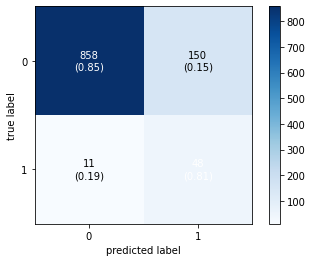

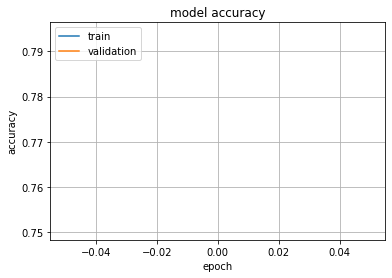

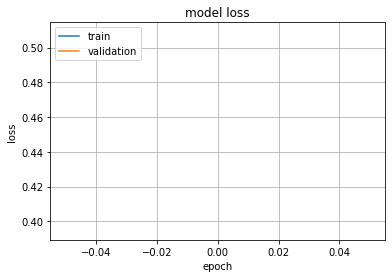

save transformer model for Adware
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Research/CyberBERT/model/Adware_transformer_model.csv/assets


In [ ]:
def train_transformer_model_one_class(class_label, x_train, y_train, x_val, y_val):

  print(f"training model for {class_label}")
  transformer = initialize_transformer()
  transformer.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
  history = transformer.fit(
      x_train, y_train, batch_size=32, epochs=1, validation_data=(x_val, y_val)
  )
  return history, transformer

SAVE_PATH = "/content/drive/My Drive/Research/CyberBERT/model/{filename}.csv"

for class_label in CLASSES: 

  y_train, x_train, y_val, x_val, y_test, x_test = load_and_process_data(class_label)
  history, transformer = train_transformer_model_one_class(class_label, x_train, y_train, x_val, y_val)
  get_prediction_accuracy(y_test, x_test, transformer, class_label, history)
  print(f"save transformer model for {class_label}")
  transformer.save(SAVE_PATH.format(filename= f"{class_label}_transformer_model"))


## Benchmark models

### LSTM from the paper that created this dataset

In [ ]:
def get_prediction_accuracy_LSTM(y_test, x_test, model, class_label, history):
  y_test_pred = transformer.predict(x_test)
  y_classes = y_test_pred.argmax(axis=-1)
  cm = confusion_matrix(y_test, y_classes)

  cm = plot_confusion_matrix(conf_mat=cm,
                        show_absolute=True,
                        show_normed=True,
                        colorbar=True)
  plt.show()
  plt.savefig(f"confusion_matrix_{class_label}.png")

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.grid()
  plt.savefig(f"accuracy_{class_label}.png")
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.grid()
  plt.savefig(f"loss_{class_label}.png")
  plt.show()

Epoch 1/10
4/4 [==============================] - 7s 2s/step - loss: 0.3657 - accuracy: 0.5067 - val_loss: 0.2556 - val_accuracy: 0.4935
Epoch 2/10
4/4 [==============================] - 7s 2s/step - loss: 0.2414 - accuracy: 0.5730 - val_loss: 0.2340 - val_accuracy: 0.5065
Epoch 3/10
4/4 [==============================] - 7s 2s/step - loss: 0.2107 - accuracy: 0.6637 - val_loss: 0.1983 - val_accuracy: 0.6829
Epoch 4/10
4/4 [==============================] - 7s 2s/step - loss: 0.2322 - accuracy: 0.6475 - val_loss: 0.1723 - val_accuracy: 0.7624
Epoch 5/10
4/4 [==============================] - 7s 2s/step - loss: 0.1607 - accuracy: 0.7815 - val_loss: 0.1518 - val_accuracy: 0.7906
Epoch 6/10
4/4 [==============================] - 7s 2s/step - loss: 0.1862 - accuracy: 0.7250 - val_loss: 0.1596 - val_accuracy: 0.7664
Epoch 7/10
4/4 [==============================] - 7s 2s/step - loss: 0.1450 - accuracy: 0.8020 - val_loss: 0.1396 - val_accuracy: 0.8269
Epoch 8/10
4/4 [=========================

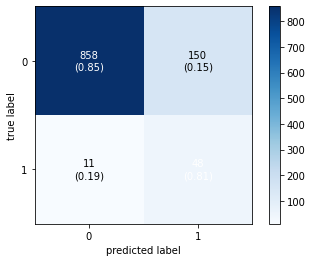

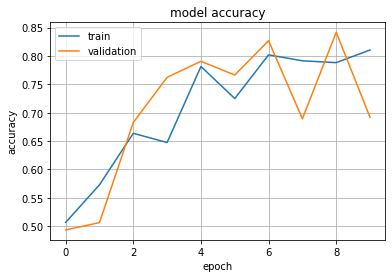

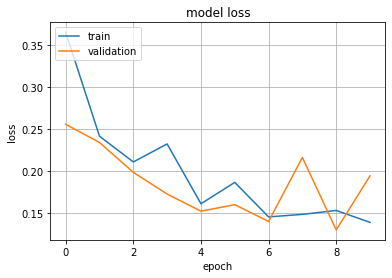

save LSTM model for Adware
INFO:tensorflow:Assets written to: /content/drive/My Drive/Research/CyberBERT/model/Adware_LSTM_model.csv/assets


In [ ]:

def malware_model(vocab_size, embed_dim, max_len, act_func="softsign"):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, input_length=max_len))
    model.add(SpatialDropout1D(0.1))
    model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1,
                   return_sequences=True, activation=act_func))
    model.add(LSTM(32, dropout=0.1, activation=act_func, return_sequences=True))
    model.add(LSTM(32, dropout=0.1, activation=act_func))
    model.add(Dense(128, activation=act_func))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation=act_func))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation=act_func))
    model.add(Dropout(0.1))
    model.add(Dense(1, name='out_layer', activation="linear"))
    return model

def train_lstm_model_one_class(class_label, x_train, y_train, x_val, y_val):

  vocab_size = 283
  output_dim = 50
  max_len = 100
  model = malware_model(vocab_size, output_dim, max_len)
  model.compile(loss='mse', optimizer="rmsprop",
                metrics=['accuracy'])
  history = model.fit(x_train, y_train, batch_size=1000, epochs=10,
                      validation_data=(x_val, y_val), verbose=1)
  
  return history, model

SAVE_PATH = "/content/drive/My Drive/Research/CyberBERT/model/{filename}.csv"

for class_label in CLASSES: 

  y_train, x_train, y_val, x_val, y_test, x_test = load_and_process_data(class_label)
  history, model = train_lstm_model_one_class(class_label, x_train, y_train, x_val, y_val)
  get_prediction_accuracy_LSTM(y_test, x_test, model, class_label, history)

  print(f"save LSTM model for {class_label}")
  model.save(SAVE_PATH.format(filename= f"{class_label}_LSTM_model"))


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


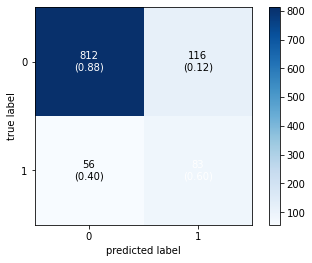

In [ ]:
# ## TO DO: update as below
# ### WARNING:tensorflow:From <ipython-input-43-f0d47c322d5c>:1: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
# # Instructions for updating:
# # Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
# y_test_pred = model.predict_classes(x_test)
# cm = confusion_matrix(y_test, y_test_pred)

# plot_confusion_matrix(conf_mat=cm,
#                       show_absolute=True,
#                       show_normed=True,
#                       colorbar=True)
# # plt.savefig("confusion_matrix.png")
# plt.show()